# Model B: Protein Generator Diffusion model conditioned on residue-level secondary structure content


**Citing this work**

Any publication that discloses findings arising from using this notebook should cite the following work.

B. Ni, D.L. Kaplan, M.J. Buehler, Generative design of de novo proteins based on secondary structure constraints using an attention-based diffusion model, Chem, 2023

In [1]:
import torch
import os

In [2]:
IF_Local_Debug = 1
# change this to 0 when making your test run

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                                  else "cpu")
# device
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# available_gpus
num_of_gpus = torch.cuda.device_count()
print('# of GPUs: ', num_of_gpus)

# of GPUs:  1


In [4]:
if IF_Local_Debug == 1:
        # for local test
        prefix='../Local_Store/output_model_B/'
else:
        prefix = 'output_model_B/'

if not os.path.exists(prefix):
        print('Create new folder for Model B')
        os.mkdir (prefix)

#### Define model

In [5]:
# Load dataset
ynormfac=21.
Xnormfac=9.
batch_size_=256
max_length = 128

# define the model
pred_dim=1
train_unet_number=1 #have only one unet, so must be 1
#model parameters

dim=256
text_embed_dim = 512
embed_dim_position=32
text_embed_dim=text_embed_dim+embed_dim_position
cond_dim = 512
cond_images_channels=1

In [6]:
from ProteinDiffusionGenerator.transformer_Model_B import OneD_Unet, ProteinDesigner_B, params

2023-04-24 12:11:14.516849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 12:11:15.156190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
unet = OneD_Unet(
        dim = dim,  
        text_embed_dim = text_embed_dim,
        cond_dim = cond_dim, #this is where text embeddings are projected to... 
        dim_mults = (1, 2, 4, 8),
            
        num_resnet_blocks = 1, 
        layer_attns = (False, True, True, False),
        layer_cross_attns = (False, True, True, False),
        channels=pred_dim,
        channels_out=pred_dim ,       
        
        attn_dim_head = 64,
        attn_heads = 8,
        ff_mult = 2.,
        lowres_cond = False,                # for cascading diffusion - https://cascaded-diffusion.github.io/
        cond_images_channels = cond_images_channels,
        layer_attns_depth =1, 
        layer_attns_add_text_cond = True,   # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        attend_at_middle = True,            # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
       
        use_linear_attn = False,
        use_linear_cross_attn = False,
        cond_on_text = True,
        max_text_len = max_length,
        init_dim = None,
        resnet_groups = 8,#8,
        init_conv_kernel_size =7,           # kernel size of initial conv, if not using cross embed
        init_cross_embed = False, #TODO - fix ouput size calcs for conv1d
        init_cross_embed_kernel_sizes = (3, 7, 15),
        cross_embed_downsample = False,
        cross_embed_downsample_kernel_sizes = (2, 4),
        attn_pool_text = True,
        attn_pool_num_latents = 32,   #perceiver model latents 
        dropout = 0.,
        memory_efficient = False,
        init_conv_to_final_conv_residual = False,
        use_global_context_attn = True,
        scale_skip_connection = True,
        final_resnet_block = True, #True,
        final_conv_kernel_size = 3,#3,
        cosine_sim_attn = True,
        self_cond = False,
        combine_upsample_fmaps = True,      # combine feature maps from all upsample blocks, used in unet squared successfully
        pixel_shuffle_upsample = False   ,     # may address checkboard artifacts
   
        ).to(device)

256 1


In [8]:
pred_dim=1
model_B =ProteinDesigner_B(
  unet,
  timesteps=(96,), 
  dim=dim, 
  pred_dim=pred_dim, 
  loss_type=0, elucidated=True,
  padding_idx=0,
  max_text_len=max_length,
  cond_images_channels=pred_dim, #f >0 then wil use cond_images instead of text embdding (or can use both)
  # +++++++++++++++++++++++++++++
  max_length=max_length,
  ynormfac=ynormfac,
  Xnormfac=Xnormfac,
  )  .to(device) 
 
print ("Total model: ")
params ( model_B)
print ("Unet only: ")
params (model_B.imagen.unets[0])

Model B: Generative protein diffusion model, residue-based
Use conditioning image during training....
Channels in=1, channels out=1
256 1
Device used in ImagenEluc:  cuda:0
Total model: 
Total model parameters:  262388274  trainable parameters:  262388274
Unet only: 
Total model parameters:  262381970  trainable parameters:  262381970


In [9]:
# download the pretrained model
train_model=False #do not train if false

if not train_model:
  model_weight_file = prefix+'Model_B_final.pt'

  file_exists = os.path.exists(model_weight_file)
  if not (file_exists):
    # download things
    print(os.popen(f"wget https://www.dropbox.com/s/wk8sizfbfjaz6yy/Model_B_final.pt -P {prefix}").read())

In [10]:
# load the model
fname=f"{prefix}Model_B_final.pt"
model_B.load_state_dict(torch.load(fname))

<All keys matched successfully>

#### Inference

In [11]:
# load in the tokenizer
import pickle
tokenizer_file = prefix+'Model_B_tokenizers.dat'

# https://github.com/Bo-Ni/ProtenDiffusionGenerator_pip/raw/main/utility/Model_B_tokenizers.dat
file_exists = os.path.exists(tokenizer_file)
if not (file_exists):
  # download things
  print("Downloading tokenizer file...")
  print(os.popen(F"wget https://github.com/Bo-Ni/ProtenDiffusionGenerator_pip/raw/main/utility/Model_B_tokenizers.dat -P {prefix}").read())

with open(tokenizer_file, "rb") as f:
 tokenizer_data_1 = pickle.load(f)
  # print(pickle.load(f))
# print(tokenizer_data_1[0])
tokenizer_X = tokenizer_data_1[0]
tokenizer_y = tokenizer_data_1[1]

In [12]:
from ProteinDiffusionGenerator.transformer_Model_B import sample_sequence, get_DSSP_result, string_diff, iterate_adaptive

Producing 1 samples...from image conditingig x_data  ...
['~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.00

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

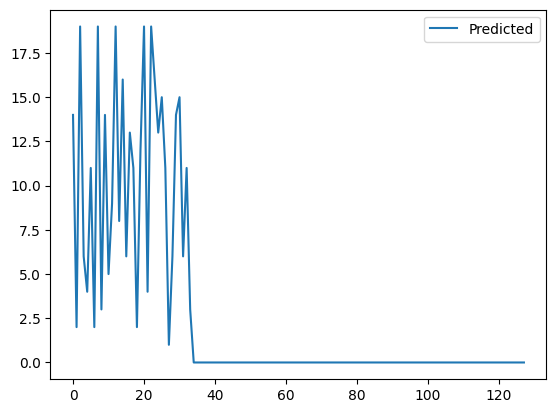

(1, 128)
For None or ~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~, predicted sequence QGMSERGMKQATMDYSNRGPMEMYNFRLSQFSRK
Writing FASTA file:  ../Local_Store/output_model_B/fasta_in_0_AH_.fasta
Now run OmegaFold.... on device=cuda:0
omegafold ../Local_Store/output_model_B/fasta_in_0_AH_.fasta ../Local_Store/output_model_B/ --num_cycle 16 --device=cuda:0


/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(
Traceback (most recent call last):
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/bin/omegafold", line 8, in <module>
    sys.exit(main())
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/omegafold/__main__.py", line 55, in main
    model.to(args.device)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/nn/modules/module.py", line 927, in to
    return self._apply(convert)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/n

INFO:root:Loading weights from /home/bni/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold

Done OmegaFold
Resulting PDB file...:  ../Local_Store/output_model_B/temp_0_AH_.pdb
Debug 1: out:  ../Local_Store/output_model_B/~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~_0_AH__0.pdb
Debug 2: in:  ../Local_Store/output_model_B/temp_0_AH_.pdb
Properly named PDB file produced: ../Local_Store/output_model_B/~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~_0_AH__0.pdb


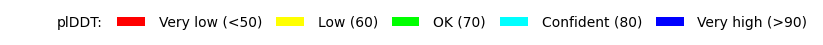

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

 INPUT:        ~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~
RESULT:       ~~SHHHHHHHHHHHHHS~HHHHHHHHHHHHHHH~
AA sequence:  QGMAGRGRMQAAFIFSMPYRIMRRIFALRQQARG
 Error:  0.11764705882352941


In [13]:
input_SS_seq = '~~HHHHHHHHHHHHHHHHHHHHHHHHHHHHHH~~' #@param {type:"string"}
output_file_flag = '0_AH_' #@param {type:"string"}
FoldProteinOrNot = True 
## #@param ["False", "True"] {type:"raw"}

fname = sample_sequence (
    model_B,
    x_data=[input_SS_seq],
    flag=output_file_flag,
    cond_scales=1.,
    foldproteins=FoldProteinOrNot,
    prefix=prefix,
    tokenizer_X=tokenizer_X,
    tokenizer_y=tokenizer_y,
    Xnormfac=Xnormfac,
    ynormfac=ynormfac,
    max_length=max_length,
     
   )

#test for single case
DSSPresult,_,sequence_res=get_DSSP_result(fname) 

print (f"\033[1;32m INPUT:        {input_SS_seq}\nRESULT:       {DSSPresult}\nAA sequence:  {sequence_res}")
error=string_diff (DSSPresult, input_SS_seq)/len (input_SS_seq)
print ("\033[1;32m Error: ", error)

# for display purpose

Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.00

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

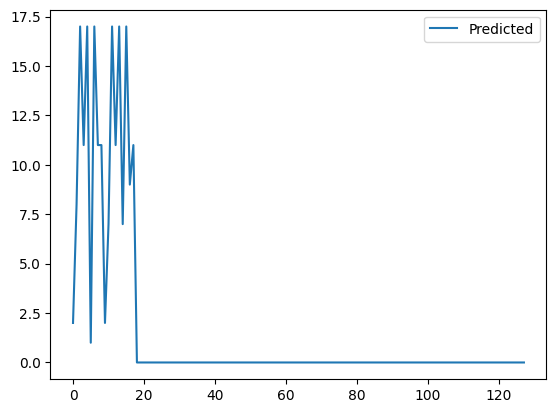

(1, 128)
For None or ~~EEEEEETTEEEEEE~~, predicted sequence GDCRCLCRRGVCRCVCTR
Writing FASTA file:  ../Local_Store/output_model_B/fasta_in_1_BS_.fasta
Now run OmegaFold.... on device=cuda:0
omegafold ../Local_Store/output_model_B/fasta_in_1_BS_.fasta ../Local_Store/output_model_B/ --num_cycle 16 --device=cuda:0


/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(
Traceback (most recent call last):
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/bin/omegafold", line 8, in <module>
    sys.exit(main())
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/omegafold/__main__.py", line 55, in main
    model.to(args.device)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/nn/modules/module.py", line 927, in to
    return self._apply(convert)
  File "/HDD_bni/1_git_projects/VirEnv_Publication/2_test/lib/python3.9/site-packages/torch/n

INFO:root:Loading weights from /home/bni/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold

Done OmegaFold
Resulting PDB file...:  ../Local_Store/output_model_B/temp_1_BS_.pdb
Debug 1: out:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~_1_BS__0.pdb
Debug 2: in:  ../Local_Store/output_model_B/temp_1_BS_.pdb
Properly named PDB file produced: ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~_1_BS__0.pdb


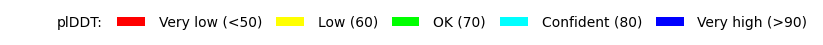

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

 INPUT:        ~~EEEEEETTEEEEEE~~
RESULT:       ~~EEEEEETTEEEEEE~~
AA sequence:  GDCRCLCRRGDCRCTCTR
 Error:  0.0


In [14]:
input_SS_seq = '~~EEEEEETTEEEEEE~~' #@param {type:"string"}
output_file_flag = '1_BS_' #@param {type:"string"}
FoldProteinOrNot = True 
## #@param ["False", "True"] {type:"raw"}


m_cycle= 16 #cycles used in OmegaFold
fname = sample_sequence (
  model_B,
  x_data=[input_SS_seq],
  flag=output_file_flag,
  cond_scales=1.,
  foldproteins=FoldProteinOrNot,
  num_cycle=m_cycle, # for omegafold
  # ++++++++++++++++++++
  prefix=prefix,
  tokenizer_X=tokenizer_X,
  tokenizer_y=tokenizer_y,
  Xnormfac=Xnormfac,
  ynormfac=ynormfac,
  max_length=max_length,
   )

#test for single case
DSSPresult,_,sequence_res=get_DSSP_result(fname) 

print (f"\033[1;32m INPUT:        {input_SS_seq}\nRESULT:       {DSSPresult}\nAA sequence:  {sequence_res}")
error=string_diff (DSSPresult, input_SS_seq)/len (input_SS_seq)
print ("\033[1;32m Error: ", error)

Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

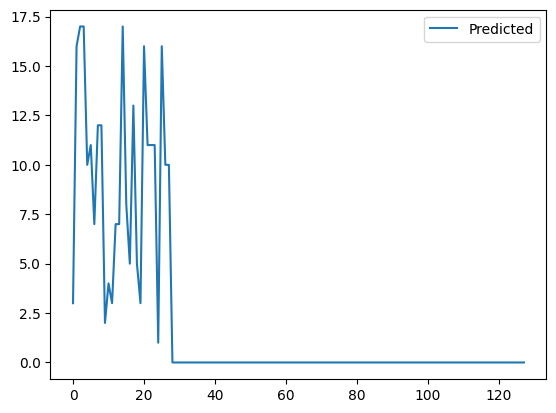

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence KYCCIRVPPGEKVVCDANAKYRRRLYII
Writing FASTA file:  ../Local_Store/output_model_B/fasta_in_3_BS_AH__0.fasta
Now run OmegaFold.... on device=cuda:0
Now run OmegaFold.... on device=cpu
omegafold ../Local_Store/output_model_B/fasta_in_3_BS_AH__0.fasta ../Local_Store/output_model_B/ --num_cycle 16 --device=cpu


/HDD_bni/1_git_projects/VirEnv_Publication/1_test/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


INFO:root:Loading weights from /home/bni/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ../Local_Store/output_model_B/fasta_in_3_BS_AH__0.fasta
INFO:root:Predicting 1th chain in ../Local_Store/output_model_B/fasta_in_3_BS_AH__0.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 32.76 seconds.
INFO:root:Saving prediction to ../Local_Store/output_model_B/temp_3_BS_AH__0.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  ../Local_Store/output_model_B/temp_3_BS_AH__0.pdb
Debug 1: out:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__0_0.pdb
Debug 2: in:  ../Local_Store/output_model_B/temp_3_BS_AH__0.pdb
Properly named PDB file produced: ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__0_0.pdb


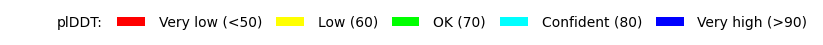

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 0: PDB file predicted:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__0_0.pdb Error:  0.35714285714285715
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEETTTEEEEEES~GGGGTGGG~~
Producing 1 samples...from image conditingig x_data  ...
['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
Device:  cuda:0
X_cond= None
Conditioning target sequence provided via x_data ... ['~~EEEEEETTEEEEEE~~HHHHHHHH~~']
x_data from target sequence= tensor([[[0.2222, 0.2222, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.4444, 0.4444, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
          0.2222, 0.2222, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111, 0.1111, 0.2222, 0.2222, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

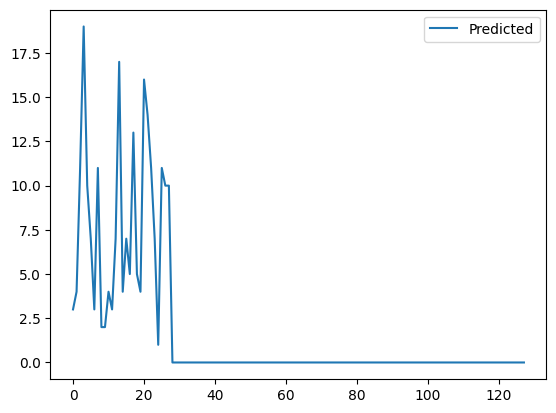

(1, 128)
For None or ~~EEEEEETTEEEEEE~~HHHHHHHH~~, predicted sequence KERMIVKRGGEKVCEVANAEYQRVLRII
Writing FASTA file:  ../Local_Store/output_model_B/fasta_in_3_BS_AH__1.fasta
Now run OmegaFold.... on device=cuda:0
Now run OmegaFold.... on device=cpu
omegafold ../Local_Store/output_model_B/fasta_in_3_BS_AH__1.fasta ../Local_Store/output_model_B/ --num_cycle 16 --device=cpu


/HDD_bni/1_git_projects/VirEnv_Publication/1_test/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


INFO:root:Loading weights from /home/bni/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading ../Local_Store/output_model_B/fasta_in_3_BS_AH__1.fasta
INFO:root:Predicting 1th chain in ../Local_Store/output_model_B/fasta_in_3_BS_AH__1.fasta
INFO:root:28 residues in this chain.
INFO:root:Finished prediction in 32.54 seconds.
INFO:root:Saving prediction to ../Local_Store/output_model_B/temp_3_BS_AH__1.pdb
INFO:root:Saved
INFO:root:Done!

Done OmegaFold
Resulting PDB file...:  ../Local_Store/output_model_B/temp_3_BS_AH__1.pdb
Debug 1: out:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0.pdb
Debug 2: in:  ../Local_Store/output_model_B/temp_3_BS_AH__1.pdb
Properly named PDB file produced: ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0.pdb


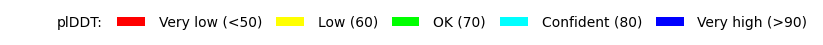

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Iteration 1: PDB file predicted:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0.pdb Error:  0.10714285714285714
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEEETTEEEEEEEHHHHHHHHHH~


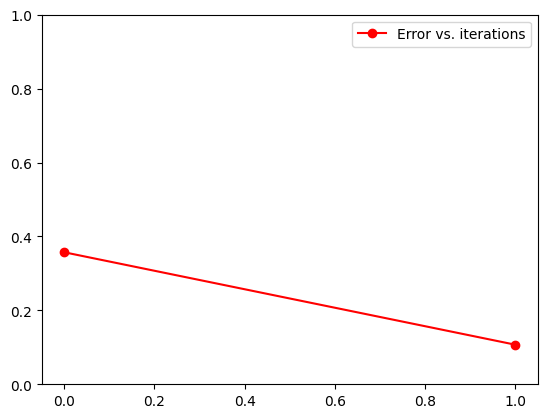

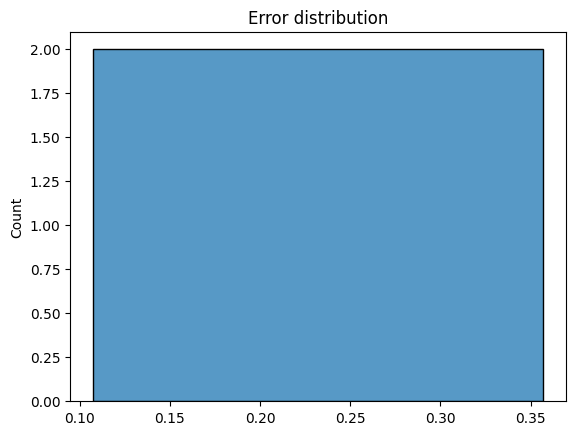

####################################################
####################################################
####################################################
FINAL RESULT at 1:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0.pdb Error:  0.10714285714285714
Seq:  KERMIVKRGGEKVCEVANAEYQRVLRII
Cond: ~~EEEEEETTEEEEEE~~HHHHHHHH~~
Pred: ~~EEEEEETTEEEEEEEHHHHHHHHHH~
FINAL FILE NAME at 1:  ../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0_FINAL.pdb
####################################################
####################################################
####################################################


('../Local_Store/output_model_B/~~EEEEEETTEEEEEE~~HHHHHHHH~~_3_BS_AH__1_0.pdb',
 0.10714285714285714,
 '~~EEEEEETTEEEEEE~~HHHHHHHH~~',
 '~~EEEEEETTEEEEEEEHHHHHHHHHH~')

In [28]:
#@title ####4-2. Generate sequence via a iterative process

#@markdown Example 3: Beta sheet + alpha helix 

input_SS_seq = '~~EEEEEETTEEEEEE~~HHHHHHHH~~' #@param {type:"string"}
# output_file_flag = '2_iter_' #@param {type:"string"}
# FoldProteinOrNot = True #@param ["False", "True"] {type:"raw"}
error_threshold = 0.2 #@param {type:"slider", min:0.0, max:1, step:0.01}
max_iter = 10 #@param {type:"slider", min:0, max:100, step:1}
output_file_flag = '3_BS_AH_'

flag='2_iter_'

iterate_adaptive (model_B,  
                  seq=input_SS_seq,
                  flag=output_file_flag, 
                  errorthreshold=error_threshold,                 
                  maxiter=max_iter,
                  #++++++++++++++++++++
                  prefix=prefix,
                  tokenizer_X=tokenizer_X,
                  tokenizer_y=tokenizer_y,
                  Xnormfac=Xnormfac,
                  ynormfac=ynormfac,
                  max_length=max_length)